In [1]:
import pandas as pd
import numpy as np

In [2]:
# # effect size tables # #
#FDR - 0.05
mcll=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.05/filtered.a4.20230115_effect_sizes.txt",sep=' ')
ucll=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.05/filtered.a6.20230115_effect_sizes.txt",sep=' ')
mucll=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.05/filtered.a2.20230115_effect_sizes.txt",sep=' ')

In [3]:
# # junction column, cll column # #
table = pd.merge(mcll[['intron','unmut','mut','deltapsi']],ucll[['intron','unmut','mut','deltapsi']], how='outer')
table=pd.merge(table, mucll[['intron','unmut','mut','deltapsi']], how='outer')
table['analysis_set'] = None
table.loc[table['intron'].isin(mcll['intron']), 'analysis_set'] = 'm'
table.loc[table['intron'].isin(ucll['intron']), 'analysis_set'] = 'u'
table.loc[table['intron'].isin(mucll['intron']),'analysis_set' ] = 'mu'
#table.rename({'intron':'junction'},inplace=True)
table[['junction','cluster']]=table['intron'].str.rsplit(':',expand=True,n=1)
# table.drop(columns='intron',inplace=True)
# table = table.reindex(columns=['junction','analysis_set','cluster'])

In [4]:
# # cluster significance # # 
#FDR - 0.05
mcll=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.05/filtered.a4.20230115_cluster_significance.txt",sep=' ')
ucll=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.05/filtered.a6.20230115_cluster_significance.txt",sep=' ')
mucll=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.05/filtered.a2.20230115_cluster_significance.txt",sep=' ')

In [5]:

cluster_table=pd.merge(mcll[['cluster','p.adjust']],ucll[['cluster','p.adjust']],on='cluster',how='outer',suffixes=['_m','_u'])
cluster_table=cluster_table.merge(mucll[['cluster','p.adjust']],on='cluster',how='outer',suffixes=['_mu'])
cluster_table['cluster']=cluster_table['cluster'].str.rsplit(':',expand=True,n=1)[1]

In [7]:
table=table.merge(cluster_table,how='left',on='cluster')

In [ ]:
table["chrom"]=table['intron'].str.rsplit(':',expand=True,n=3)[0]
table["chrom"]=table["chrom"].str.replace('chr','')

In [8]:
# gene name
import pyensembl
table['gene_name']=pd.NaT
# table['identified']=pd.NaT
data = pyensembl.Genome(
    reference_name='GRCh37',
    annotation_name='my_genome_lab',
    gtf_path_or_url='/private1/private/resources/gencode19_noChrPrefix_mitoMT.gtf')
data.index()
for i,j in enumerate(table.junction):
    j=j.split(':')
    chr=j[0].replace('chr','')
    start=int(j[1])
    end=int(j[2])
    gene_name = data.gene_names_at_locus(contig=chr, position=start,end=end)
    if gene_name != []:
        table.at[i,'gene_name']=gene_name
    

table.dropna(subset=['gene_name'], inplace=True)


In [9]:
# filter out when unmut bigger than mut (deltapsi < 1) #
table.rename(columns={'p.adjust':'p.adjust_mu'},inplace=True)
table = table[table.deltapsi > 0] # mut-unmut >1

In [75]:
# table.to_csv("/home/ls/rachelcw/projects/BIO/table.20230123.csv",index=0)

table=pd.read_csv("/home/ls/rachelcw/projects/BIO/table.20230123.csv")

In [90]:
# the junction (event) is identified in GTF (known 5, known 3, known junction, novel), add strand column (+\-) #
fiveprime=pd.read_csv("/home/ls/rachelcw/projects/BIO/annontation_code.20221225_fiveprime.bed.gz", sep='\t',compression='gzip', header=None,usecols=[0,1,5,8] ,names=['chrom', 'start_int',  'strand','type'])
fiveprime['chrom'] = fiveprime['chrom'].astype(str)
fiveprime= fiveprime.loc[(fiveprime.type=='protein_coding')|(fiveprime.type=='lncRNA')]
threeprime=pd.read_csv("/home/ls/rachelcw/projects/BIO/annontation_code.20221225_threeprime.bed.gz", sep='\t',compression='gzip', header=None, usecols=[0,1,5,8] ,names=['chrom', 'start_int',  'strand','type'])
threeprime['chrom'] = threeprime['chrom'].astype(str)
threeprime= threeprime.loc[(threeprime.type=='protein_coding') | (threeprime.type=='lncRNA')]
table['identified gtf']=pd.NaT
table['strand']= pd.NaT

for chr in fiveprime.chrom.unique():
    fiveprime_chr=fiveprime.loc[fiveprime.chrom==chr]
    threeprime_chr=threeprime.loc[threeprime.chrom==chr]
    chr_table=table.loc[table.chrom==chr]
    for junc in chr_table.junction:
        junction=junc.split(':')
        # chr=junction[0].replace('chr','')
        start=int(junction[1])
        end=int(junction[2])
        annotation= ""
        counter = 0
        if fiveprime_chr['start_int'].isin([start]).any():
            annotation= "known 5'"
            counter = counter +1
            strand=list(fiveprime_chr.loc[fiveprime_chr.start_int==start,'strand'])[0]
            table.loc[table.junction==junc,'strand']=strand
        if threeprime_chr['start_int'].isin([end]).any():
            annotation= "known 3'"
            counter = counter +1
            strand=list(threeprime_chr.loc[threeprime_chr.start_int==end,'strand'])[0]
            table.loc[table.junction==junc,'strand']= strand
        if counter == 2:
            annotation = "known junction"
        if counter == 0:
            annotation = "novel"
        table.loc[table.junction==junc,'identified gtf']=annotation
        
        

/home/ls/rachelcw/miniconda3/envs/bio_sns/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [40]:
# table['identified gtf']=pd.NaT

# for chr in threeprime.chrom.unique():
#     start_intron_5s= fiveprime_sense.loc[fiveprime_sense.chrom==chr]
#     end_intron_5as=fiveprime_anti.loc[fiveprime_anti.chrom==chr]
#     end_intron_3s= threeprime_sense.loc[threeprime_sense.chrom==chr]
#     start_intron_3as=threeprime_sense.loc[threeprime_sense.chrom==chr]
#     chr_table=table.loc[table.chrom==chr]
#     for junc in chr_table.junction:
#         junction=junc.split(':')
#         chr=junction[0].replace('chr','')
#         start=int(junction[1])
#         end=int(junction[2])
#         annotation= ""
#         counter = 0
#         # start -> 5', end -> 3'
#         if start in start_intron_5s.start_int :
#             # sense
#             annotation= "known 5'+"
#             counter = counter +1
#         if end in end_intron_5as.start_int:
#             # anti sense
#             annotation= "known 5'-"
#             counter = counter +1
#         if end in start_intron_3as.start_int:
#             # antisense
#             annotation= "known 3'-"
#             counter = counter +1
#         if start in end_intron_3s.start_int: ## check maybe -1:
#             #sense
#             annotation= "known 3'+"
#             counter = counter +1
#         if counter == 2:
#             annotation = "known junction"
#         elif counter == 0:
#             annotation = "novel"
#         else:
#             print(counter, junc)
#         table.loc[table.junction==junc,'identified gtf']=annotation


3 chr11:247448:248776
1 chr4:724899:726189


[Text(0, 0, '2211'), Text(0, 0, '413'), Text(0, 0, '790')]

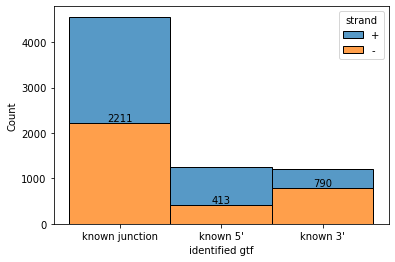

In [112]:
import seaborn as sns
plot_table=table.filter(items=["intron","identified gtf","strand"])
plot_table.drop_duplicates(inplace=True)
ax=sns.histplot(data=plot_table, x='identified gtf',hue='strand',multiple="stack")
ax.bar_label(ax.containers[0])

In [9]:
# essential gene to sf3b1 #
gene_dep=pd.read_csv("/home/ls/rachelcw/projects/CRISPR_gene_dependency.csv")

In [14]:
start=115890428
end=115890906
exons=data.genes_at_locus(contig='10', position=start,end=end)
for exon in exons:
    print(exon)
    

Gene(gene_id='ENSG00000165813.12', gene_name='C10orf118', biotype='None', contig='10', start=115880621, end=115933979, strand='-', genome='GRCh37')


In [ ]:
# # alternative 5/3 prime splice site # #
for j in table.junction:
    j=j.split(':')
    chr=j[0].replace('chr','')
    start=int(j[1])
    end=int(j[2])
    # Find the intron with the desired junction coordinates
    
    for transcript in data.transcripts(chr):
    # Iterate over the exons of the gene
        #exons=data.exon_ids_of_gene_id(gene.gene_id)
        for exon in transcript.exons:
            
            print()
            # Check if the exon has an alternative 5' splice site
            # if exon.start < end + 1:
            #     print(f'Exon {exon.id} has an alternative 5\' splice site')
            # # Check if the exon has an alternative 3' splice site
            # if exon.end == start - 1:
            #     print(f'Exon {exon.id} has an alternative 3\' splice site')